# Homework 7
#### Cody Costa, David Loi

### Problem 1:

#### Import necessary module(s)

In [238]:
import numpy as np

### Function to generate random symmetric matrix:

In [239]:
''' function to generate 2x2 symmetric matrix whose
    elements are constrained to be between 0 and 10 '''

size: int = 2
max_value: int = 10

def generate_symmetric_matrix(size) -> np.ndarray:

    matrix: np.ndarray = np.zeros([size, size])

    for element in range(size):

        # diagonal matrix
        matrix[element, element] = np.random.randint(0, max_value)

        # fill it such that matrix is symmetric
        filler = np.array([np.random.randint(0, max_value) for e in range(size - element - 1)])

        matrix[element, element + 1:] = filler
        matrix[element + 1:, element] = filler

    return matrix

    # verify the matrix has a nonzero determinant

    # if np.linalg.det(matrix):
    #     return matrix
    
    # else:
    #     generate_symmetric_matrix(size)


#### test that function works:

In [240]:
M: np.ndarray = generate_symmetric_matrix(2)
print(M)

[[2. 8.]
 [8. 3.]]


### Decomposition

use the property that a matrix A can be equated to A = PDP^T where...

#### D = diagonal matrix of eigenvalues
#### P = matrix of eigenvectors

In [241]:
eigenvalues, eigenvectors = np.linalg.eig(M)
print(eigenvalues, '\n')
print(eigenvectors)

[-5.51560977 10.51560977] 

[[-0.72882724 -0.68469764]
 [ 0.68469764 -0.72882724]]


### Find SVD of matrix

In [242]:
U, S, U_T = (np.linalg.svd(M))
print(U, '\n\n', S, '\n\n', U_T)


[[-0.68469764 -0.72882724]
 [-0.72882724  0.68469764]] 

 [10.51560977  5.51560977] 

 [[-0.68469764 -0.72882724]
 [ 0.72882724 -0.68469764]]


### Define our P and D matrices

In [243]:
# P: np.ndarray = 1 / abs(np.min(eigenvectors)) * eigenvectors
# P

P = eigenvectors
print(P)

[[-0.72882724 -0.68469764]
 [ 0.68469764 -0.72882724]]


### Craft the diagonal matrix of eigenvalues D

In [244]:
D: np.ndarray = np.zeros([size, size])
for idx, val in enumerate(S):
    D[idx, idx] = eigenvalues[idx]

print(D)

[[-5.51560977  0.        ]
 [ 0.         10.51560977]]


In [245]:
''' test our P and D matrices are accurate via A = P D P^T '''

print(P @ D @ P.T, '\n')
print(M)


[[2. 8.]
 [8. 3.]] 

[[2. 8.]
 [8. 3.]]


### More decomposition relations

let's normalize the matrix P (eigenvectors) and establish the relation m @ V == V @ D

In [246]:
P

array([[-0.72882724, -0.68469764],
       [ 0.68469764, -0.72882724]])

In [247]:
''' normalize eigenvectors '''

V = np.zeros([size, size])

V[:, 0] = P[:, 0] / np.max(abs(P[:, 0]))
V[:, 1] = P[:, 1] / np.max(abs(P[:, 1]))

In [248]:
V

array([[-1.        , -0.93945122],
       [ 0.93945122, -1.        ]])

In [249]:
''' check for correctness'''

res1 = np.round(M @ V, 2)
res2 = np.round(V @ D, 2)
print(res1, '\n\n', res2)

[[  5.52  -9.88]
 [ -5.18 -10.52]] 

 [[  5.52  -9.88]
 [ -5.18 -10.52]]


#### Given this relation, we can conclude the matrix V are the eigenvectors of m

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


### Problem 2:

### Necessary Imports

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import math

import os

from sklearn.decomposition import PCA

### Define Global Vars

In [251]:
IMAGE_ROWS: int = 28
IMAGE_SET_SIZE: int = 6

GAUSSIAN_NOISE: int = 10    # change this one for different noise levels
PCA_COUNT: int = 4

### Load Data to Compress

In [252]:
emnist_digits = pd.read_csv('emnist-digits-test.csv', header=None, sep=',', dtype='uint')
print(emnist_digits.shape)
emnist_digits.head()

(40000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Useful Accessory Functions

In [253]:
def extract_image_vector(index, dataset=emnist_digits):
    'Return a square matrix from a row in the Pandas DataFrame.'
    return emnist_digits.values[index,1:]

def add_gaussian_noise(the_vector, std_dev=GAUSSIAN_NOISE):
    'Add zero mean' 
    noise = np.random.normal(0,std_dev, len(the_vector) )
    return the_vector + noise

def mean_square_error(modified_vector, original_image_vector):
    'A distance measure between two image matrices'
    n = sum(original_image_vector.shape)
    # print('n', n)
    if n != sum(modified_vector.shape):
        print(f'Vector lengths do not match: {n}')
        return None
    # Compute mean sum of squares
    rmse = math.sqrt(np.square(modified_vector - original_image_vector).sum())/n
    return rmse

# Test - comparing a vector with iteself should equal 0
mean_square_error(emnist_digits.values[9,1:], emnist_digits.values[9,1:])

0.0

### Example Function To View An Image

In [254]:
def view_one_image(index, dataset=emnist_digits):
    '''Take one row of the data that contains one image, 
    reshape it to a square for display, and return the class'''
    the_class = emnist_digits.values[index, 0]
    
    the_vector = extract_image_vector(index, dataset)

    image = plt.imshow(the_vector.reshape(IMAGE_ROWS, IMAGE_ROWS).T, cmap='GnBu')
    plt.show(image)
    return the_class

# view_one_image(4)

### Digit To Compress And Reconstruct (CAN CHANGE THIS)

In [255]:
DIGIT = 4

### Gather Images To Compress

In [256]:
training_images = np.zeros([IMAGE_SET_SIZE, IMAGE_ROWS**2])

row = 0

for j in range(emnist_digits.shape[0]):
    current_digit = emnist_digits.values[j, 0]
    
    if current_digit == DIGIT:

        training_images[row, :] = extract_image_vector(j)

        row += 1

        if row >= IMAGE_SET_SIZE:
            break


print(f'Training shape {training_images.shape}')

Training shape (6, 784)


### Test Showing A Raw Image

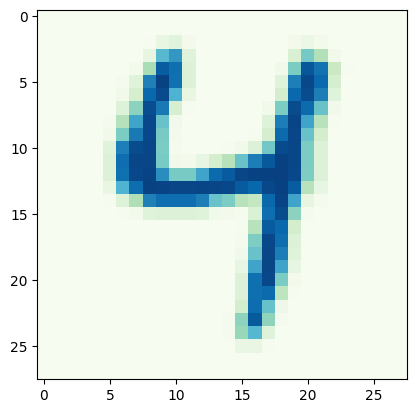

In [261]:
plt.imshow(training_images[1, :].reshape([IMAGE_ROWS, IMAGE_ROWS]).T, cmap='GnBu')

### Function To Compute Reconstruction Error (With Noise) VS Num of PCA Components

In [258]:
def vary_components(image_vector, noise_level):
    the_vector = add_gaussian_noise(image_vector, noise_level)
    train_image = the_vector.reshape(IMAGE_ROWS, IMAGE_ROWS)
    errors = np.zeros(IMAGE_ROWS)
    
    for component_count in range(2, IMAGE_ROWS):
        v_pca_model = PCA(n_components=component_count)
        v_pca_model.fit(train_image)
        image_space = v_pca_model.transform(train_image)
        image_reconstruction = v_pca_model.inverse_transform(image_space)
        base_error = mean_square_error(the_vector, image_vector)
        errors[component_count] =  mean_square_error(image_reconstruction.reshape(784), image_vector.reshape(784))

    return errors

### Compress, Reconstruct, and Plot Results

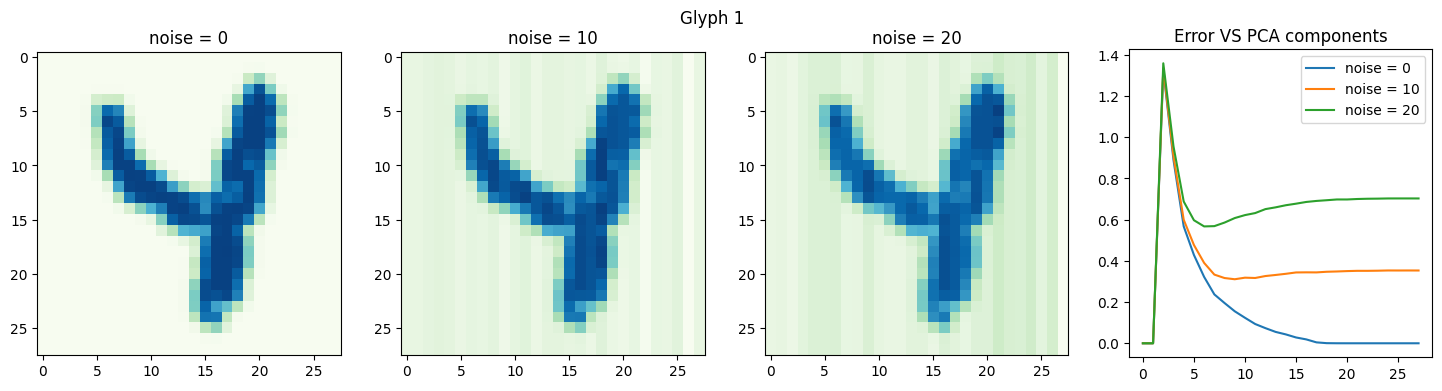

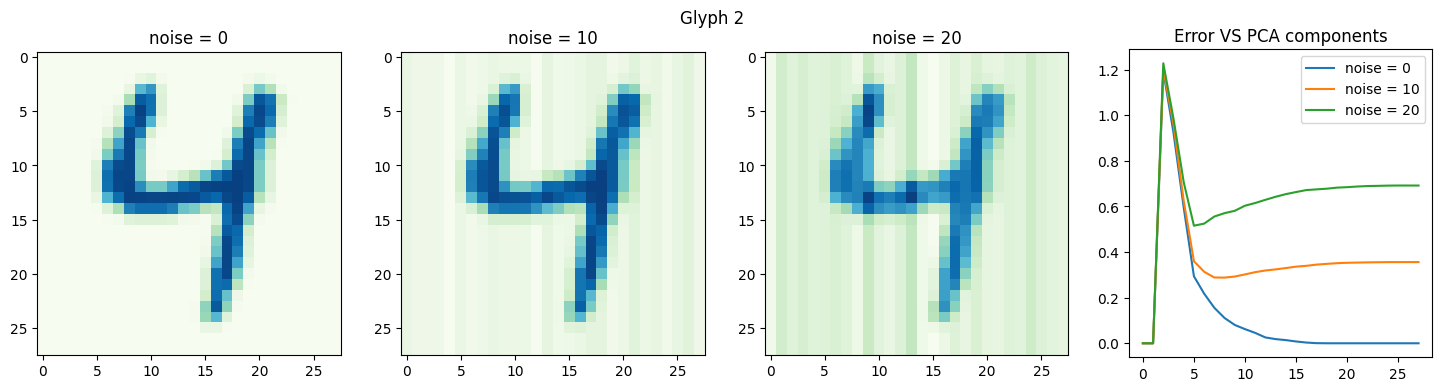

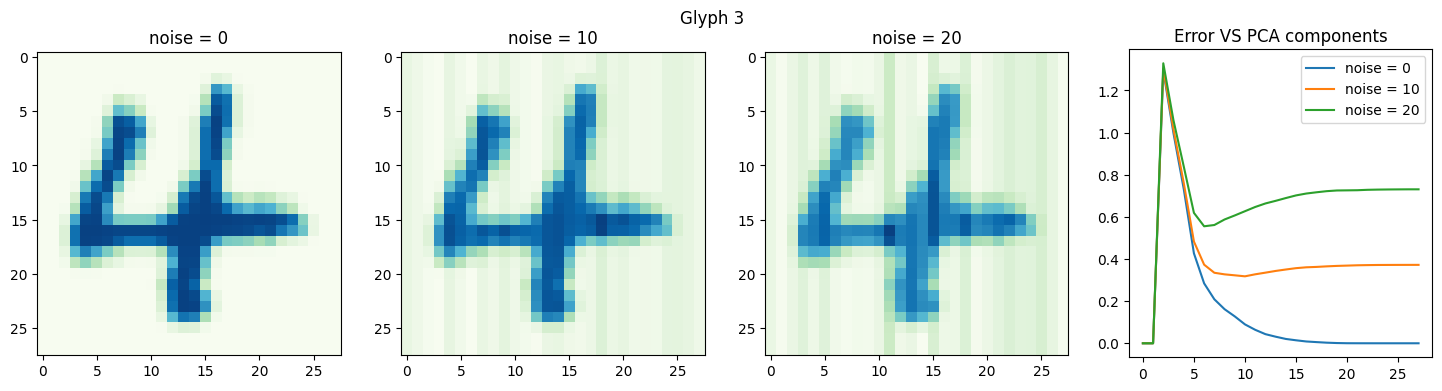

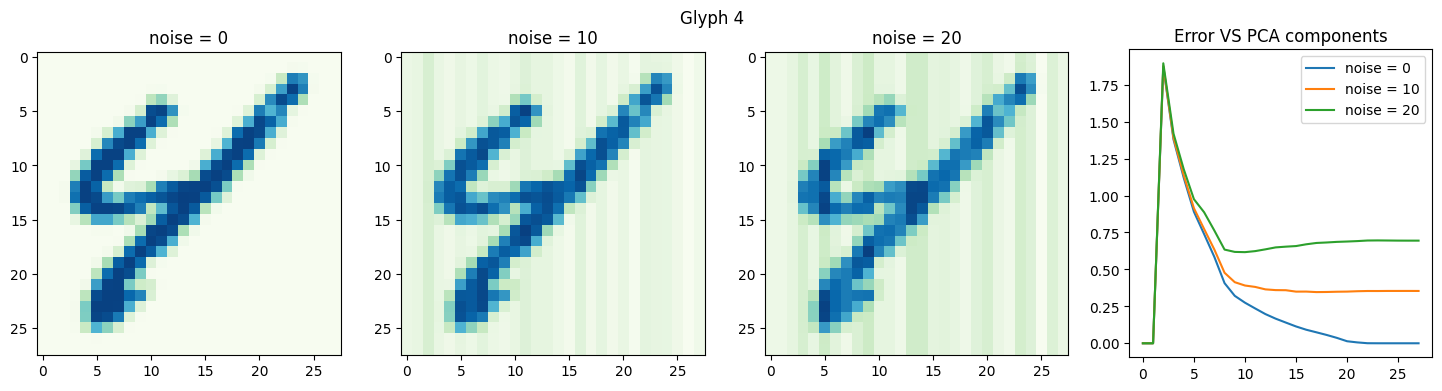

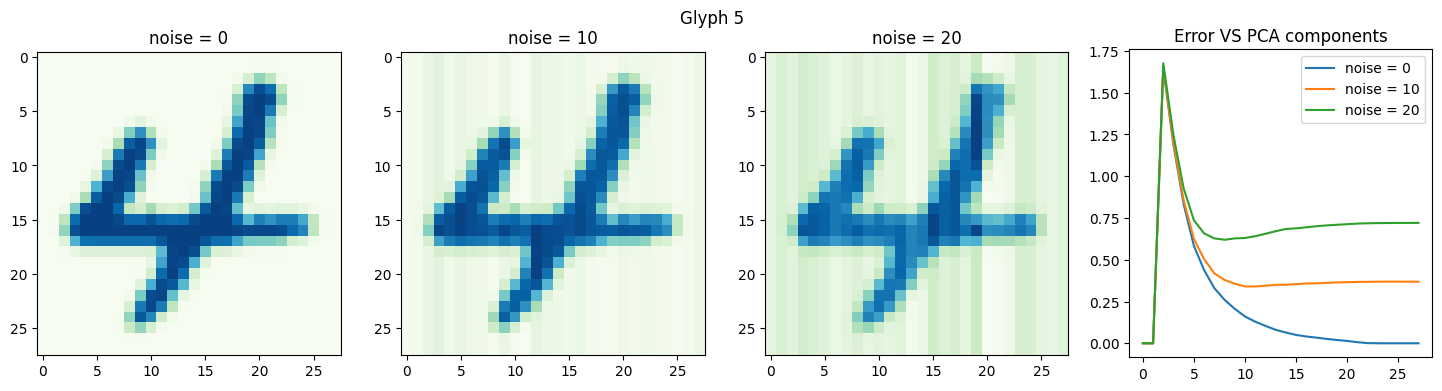

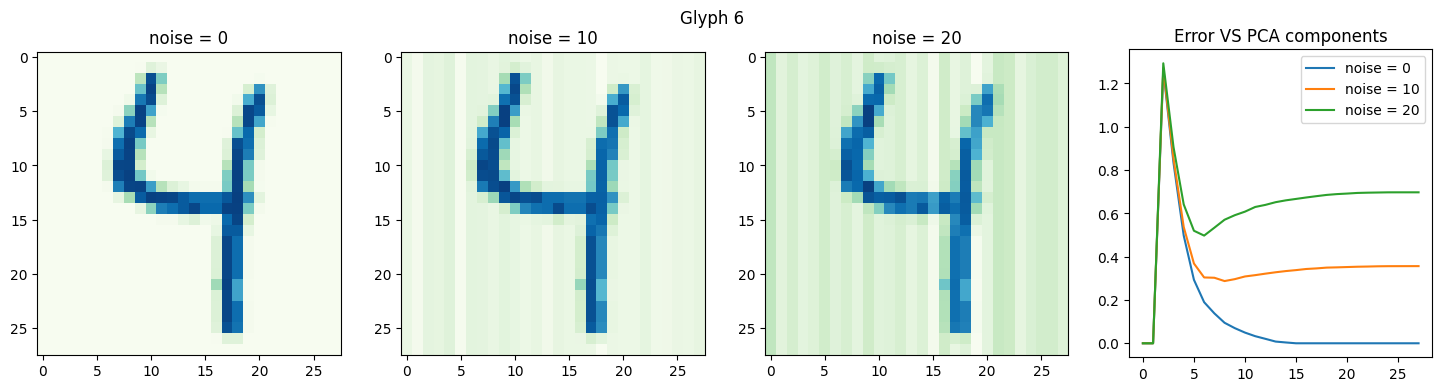

In [259]:
# print(f'Reconstruction Results For Noise Level = {GAUSSIAN_NOISE}')

num_noise_plots = 3
legend_list = []

for row in range(IMAGE_SET_SIZE):

    ''' transform each training image '''

    img = training_images[row, :].reshape([IMAGE_ROWS, IMAGE_ROWS]).T
    img_pca_model = PCA(n_components=IMAGE_ROWS)
    img_pca_model.fit(img)

    img_space = img_pca_model.transform(img)

    ''' inverse transform trainign images '''

    img_reconstruct = img_pca_model.inverse_transform(img_space)

    ''' subplots for each image reconstruction with error graph '''

    fit, axes = plt.subplots(1, num_noise_plots + 1, figsize=[18, 4])

    fit.suptitle(f'Glyph {row + 1}')
    
    for val in range(num_noise_plots):

        if val < num_noise_plots:
            axes[val].imshow(add_gaussian_noise(img_reconstruct, GAUSSIAN_NOISE * val), cmap='GnBu')
            axes[val].set_title(f'noise = {GAUSSIAN_NOISE * val}')


        axes[num_noise_plots].plot(range(IMAGE_ROWS), vary_components(training_images[row, :], GAUSSIAN_NOISE * val))
        legend_list.append(f'noise = {val * GAUSSIAN_NOISE}')

    axes[num_noise_plots].set_title('Error VS PCA components')
    axes[num_noise_plots].legend(legend_list, loc='best')

#### For no noise, beyond 20 PCA components had little increased effect on the quality of the reconstruction, therefore 20 PCA components is the upper limit to achieve the best results
#### For noisy images, between 5 and 10 PCA components tended to be the range where we see the best reconstruction results

### Save Jupyter Notebook As HTML

In [260]:
os.system('jupyter nbconvert linear-algebra-hw7.ipynb --to html')

0

#### if this command did not work, first run this command in the terminal:

> pip install nbconvert

#### then try rerunning the previous cell